# Focal Io Stimulation

## Setup

Importage

In [8]:
# Generic stuff
import os,sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d
from copy import deepcopy
import nibabel as nib

# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# CTWC model code
sys.path.append('../ctwc')
from ctwc_model import (run_net_sim,decimate_surface,plot_surface_mpl,plot_surface_mpl_mv,
                           make_brain_movie,sim_summary,FreqVsAmpPsweep)

Define some variables

In [9]:
# 1-node weights & delays
weights_1N = np.array([[1.]])
delays_1N = np.array([[1.]])

In [10]:
cv = 4.

# this rearanges the l2k8 indices to match the sorted aparc labels used in the meg analysis

l2k8_to_aparc_sort_idx = np.array([22, 21, 20, 23, 18, 17, 19, 14, 24, 30, 16, 28, 10, 25, 15, 13, 29,
       32, 31,  9, 26, 33, 27,  8,  5, 12,  7,  4,  3, 11,  0,  1,  6,  2,
       64, 62, 63, 65, 60, 59, 61, 56, 66, 72, 58, 70, 67, 71, 52, 57, 55,
       74, 73, 51, 68, 75, 69, 50, 47, 54, 49, 46, 53, 42, 43, 45, 48, 44])

orig_to_abey_idx = np.array([46, 32, 50, 58, 16,  6, 22, 42, 26, 20, 12, 34, 16,  8, 64, 18, 60,
       66, 30,  0, 62, 44, 48,  4, 56,  2, 54, 36, 40, 38, 24, 28, 52, 10,
       47, 33, 51, 59, 15,  7, 23, 43, 27, 21, 13, 35, 17,  9, 65, 19, 61,
       67, 31,  1, 63, 45, 49,  5, 57,  3, 55, 37, 41, 39, 25, 29, 53, 11])

l2k8_to_abey_idx = np.array([13, 10, 19, 17, 28, 20, 22, 21, 23, 14, 24, 25, 28, 26, 27, 33, 31,
       32, 29, 30, 16, 15,  9,  8,  7, 12,  6,  5,  4,  1,  0,  3, 11,  2,
       55, 52, 61, 59, 60, 62, 64, 63, 65, 56, 66, 67, 70, 68, 69, 75, 73,
       74, 71, 72, 58, 57, 51, 50, 49, 54, 48, 47, 46, 43, 42, 45, 53, 44])

l2k8_in_orig = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])


sfreq = 1000.    
freq_bands = {'delta': (2, 4),
              'theta': (5, 7),
              'alpha': (8, 12),
              'beta': (15, 29),
              'gamma': (30, 45)}

freqs = freq_bands.keys()

Load SC data

In [11]:
l2k8_w = np.loadtxt('../data/hcp_grpavg_l2k8_sc33_weights.npy')

l2k8_tl = np.loadtxt('../data/hcp_grpavg_l2k8_sc33_tractlengths.npy')

df_l2k8_w = pd.DataFrame(l2k8_w)

df_l2k8_tl = pd.DataFrame(l2k8_tl)

df_l2k8_w *= ((np.eye(83)*-1) + 1)
df_l2k8_wlog = np.log1p(df_l2k8_w)

df_l2k8_wlog_divmax = df_l2k8_wlog.copy()
df_l2k8_wlog_divmax/= df_l2k8_wlog.max()


df_l2k8_del = df_l2k8_tl / cv

_df_d = df_l2k8_del.copy()
_df_d[df_l2k8_wlog_divmax<0.2] = 0.

_df_w = df_l2k8_wlog_divmax.copy()
_df_w[_df_w<0.2] = 0

In [12]:
l2k8_lV1_idx = 21 # pericalcarine
l2k8_lM1_idx = 24 # precentral
l2k8_lA1_idx = 30 # superiortemporal
l2k8_lS1_idx = 22 # postcentral
l2k8_lDLPFC_idx = 12 # lateralorbitofrontal
l2k8_lVLPFC_idx = 19 # parsorbitalis

focal_nodes = [l2k8_lV1_idx,l2k8_lA1_idx,l2k8_lM1_idx,l2k8_lS1_idx,
               l2k8_lDLPFC_idx,l2k8_lVLPFC_idx]
focal_node_names = ['lV1','lA1','lM1','lS1','lDLPFC','lVLPFC']


# low resolution = sparser set ('short')
freqs_s = np.arange(0.01,100.,10./3.)
amps_s = np.arange(0,3,0.1) 

# high resolution = denser set ('long')
freqs_l = np.arange(0,100,1)
amps_l = np.arange(0.,2.05,0.05)

# 1-node weights & delays
weights_1N = np.array([[1.]])
delays_1N = np.array([[1.]])

weights_l2k8 = _df_w.values
delays_l2k8  = _df_d.values
n_nodes_l2k8 = weights_l2k8.shape[0]

In [13]:
lhi_file = '../data/fsav5_lh.inflated'
rhi_file = '../data/fsav5_rh.inflated'

lhp_file = '../data/fsav5_lh.pial'
rhp_file = '../data/fsav5_rh.pial'

lh_annot_file = '../data/fsav5_lh.aparc.annot'
rh_annot_file = '../data/fsav5_rh.aparc.annot'

lhi_vtx,lhi_tri = nib.freesurfer.read_geometry(lhi_file)
rhi_vtx,rhi_tri = nib.freesurfer.read_geometry(rhi_file)

lhp_vtx,lhp_tri = nib.freesurfer.read_geometry(lhp_file)
rhp_vtx,rhp_tri = nib.freesurfer.read_geometry(rhp_file)

lh_annot = nib.freesurfer.read_annot(lh_annot_file)
rh_annot = nib.freesurfer.read_annot(rh_annot_file)

vtx_l2k8_lh = lhp_vtx
tri_l2k8_lh = lhp_tri
rm_l2k8_lh = lh_annot[0]


vtx_l2k8_rh = rhp_vtx
tri_l2k8_rh = rhp_tri
rm_l2k8_rh = rh_annot[0]

vtx_l2k8_lhrh = np.concatenate([vtx_l2k8_lh,vtx_l2k8_rh], axis=0)
tri_l2k8_lhrh = np.concatenate([tri_l2k8_lh,tri_l2k8_rh+10242],axis=0)

rm_l2k8_rh_p1 = rm_l2k8_rh + 36
rm_l2k8_rh_p1[rm_l2k8_rh == 0] = 0

rm_l2k8_lhrh = np.concatenate([rm_l2k8_lh, rm_l2k8_rh_p1], axis=0)
rm_l2k8_lhrh

hemi = np.ones_like(rm_l2k8_lhrh)
hemi[:10242] = 0
hemi

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

## Do it

In [28]:
ssX_params = dict(I_o=0.,
             wee = 1.4,wei = 1.4,
                  wie = -2.,wii = -0.5,wertn = 0.6,weth = .6,
            wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,D_e = .0001,D_i= .0001,
            D_th = 0.0001,D_rtn = 0.0001,T = 1024,P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,g = -0.9,a_e = 0.3,
            a_i = 0.5,a_th = 0.2,a_rtn = 0.2,i_e = -0.35,i_i = -0.3,i_th = 0.5,
            i_rtn = -0.8,tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.5,
             weights=weights_1N,delays=delays_1N,K=1,
             return_ts=True,compute_connectivity=False,#True,
             stim_type='sinewave',stim_pops=['e'])

In [29]:
%%time


all_sims = {}

I_o_bg = 0.
I_o_focal = 2.0 #  1.4

for fn,fnn in zip(focal_nodes,focal_node_names):

    I_o_vec = np.ones(n_nodes_l2k8) * I_o_bg
    I_o_vec[fn] = I_o_focal
    
    newparams = deepcopy(ssX_params)
    newparams['stim_nodes'] = focal_nodes
    newparams['I_o'] = I_o_vec
    newparams['weights'] = weights_l2k8
    newparams['delays'] = delays_l2k8
    newparams['K'] = n_nodes_l2k8
    newparams['g'] = 0.9
    
    all_sims[fnn] = run_net_sim(**newparams)  
    
    
newparams = deepcopy(ssX_params)
newparams['weights'] = weights_l2k8
newparams['delays'] = delays_l2k8
newparams['K'] = n_nodes_l2k8
newparams['g'] = 0.9

newparams['I_o'] = 0.

ref_sim = run_net_sim(**newparams)  



newparams = deepcopy(ssX_params)
newparams['weights'] = weights_l2k8
newparams['delays'] = delays_l2k8
newparams['K'] = n_nodes_l2k8
newparams['g'] = 0.9

newparams['I_o'] = 0.

ref_sim_2 = run_net_sim(**newparams)  

CPU times: user 7min 32s, sys: 52 ms, total: 7min 33s
Wall time: 7min 28s


In [139]:
focal_nodes

[21, 30, 24, 22, 12, 19]

In [138]:
focal_node_names

['lV1', 'lA1', 'lM1', 'lS1', 'lDLPFC', 'lVLPFC']

In [278]:
focal_node_num = 0
focal_node_name = focal_node_names[focal_node_num]
focal_node_colnum = focal_nodes[focal_node_num]

normed = all_sims[focal_node_name][1]['e'].loc[1:55] / all_sims[focal_node_name][1]['e'].loc[1:55].sum(axis=0)
normed_ref = ref_sim[1]['e'].loc[1:55] / ref_sim[1]['e'].loc[1:55].sum(axis=0)

alphapow = all_sims[focal_node_name][1]['e'].loc[8:12].mean(axis=0).values
gammapow = all_sims[focal_node_name][1]['e'].loc[30:40].mean(axis=0).values
alphapow_onsurf = alphapow[rm_l2k8_lhrh]
gammapow_onsurf = gammapow[rm_l2k8_lhrh]

diff = normed_ref - normed
diff_alphapow = diff.loc[7:10].mean(axis=0).values
diff_gammapow = diff.loc[35:55].mean(axis=0).values
diff_alphapow_onsurf = diff_alphapow[rm_l2k8_lhrh]
diff_gammapow_onsurf = diff_gammapow[rm_l2k8_lhrh]

In [294]:
focal_node_num = 0
focal_node_name = focal_node_names[focal_node_num]
focal_node_colnum = focal_nodes[focal_node_num]

normed_2 = all_sims[focal_node_name][2]['e'].loc[1:55] / all_sims[focal_node_name][2]['e'].loc[1:55].sum(axis=0)
normed_2_ref = ref_sim[2]['e'].loc[1:55] / ref_sim[2]['e'].loc[1:55].sum(axis=0)

alphapow = all_sims[focal_node_name][2]['e'].loc[8:12].mean(axis=0).values
gammapow = all_sims[focal_node_name][2]['e'].loc[30:40].mean(axis=0).values
alphapow_onsurf = alphapow[rm_l2k8_lhrh]
gammapow_onsurf = gammapow[rm_l2k8_lhrh]

In [295]:
diff_2 = normed_2_ref - normed_2
diff_alphapow_2 = diff_2.loc[7:10].mean(axis=0).values
diff_gammapow_2 = diff_2.loc[35:55].mean(axis=0).values
diff_alphapow_2_onsurf = diff_alphapow_2[rm_l2k8_lhrh]
diff_gammapow_2_onsurf = diff_gammapow_2[rm_l2k8_lhrh]

Original power spectrum plots

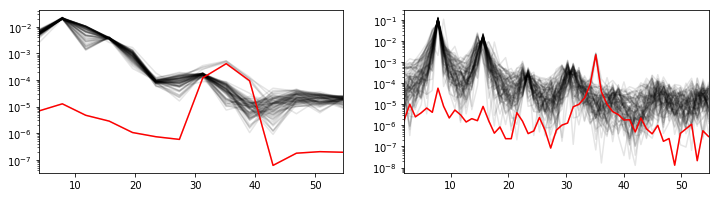

In [296]:
fig, ax = plt.subplots(ncols=2,figsize=(12,3))

all_sims[focal_node_name][1]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=0.1,c='k',)
all_sims[focal_node_name][1]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=1.,c='r')#legend=False)

all_sims[focal_node_name][2]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=0.1,c='k')
all_sims[focal_node_name][2]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=1.,c='r')#legend=False)

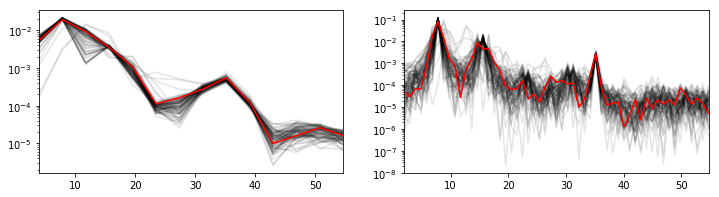

In [297]:
fig, ax = plt.subplots(ncols=2,figsize=(12,3))

ref_sim[1]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=0.1,c='k',)
ref_sim[1]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=1.,c='r')#legend=False)

ref_sim[2]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=0.1,c='k')
ref_sim[2]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=1.,c='r')#legend=False)

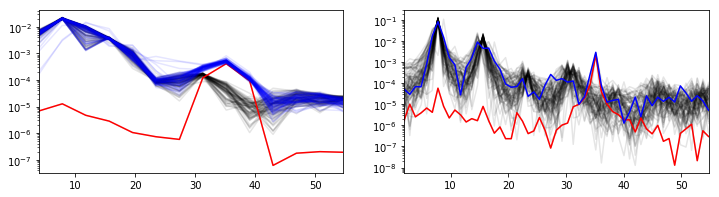

In [298]:
fig, ax = plt.subplots(ncols=2,figsize=(12,3))

all_sims[focal_node_name][1]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=0.1,c='k',)
all_sims[focal_node_name][1]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=1.,c='r')#legend=False)

all_sims[focal_node_name][2]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=0.1,c='k')
all_sims[focal_node_name][2]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=1.,c='r')#legend=False)



ref_sim[1]['e'].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=0.1,c='b',)
ref_sim[2]['e'][focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=1.,c='b')#legend=False)

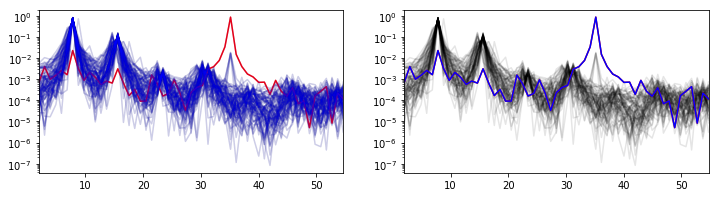

In [299]:
fig, ax = plt.subplots(ncols=2,figsize=(12,3))

normed_2.loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=0.1,c='k',)
normed_2[focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=1.,c='r')#legend=False)

normed_2.loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=0.1,c='k')
normed_2[focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=1.,c='r')#legend=False)

normed_2.loc[1:55].plot(legend=False,logy=True,ax=ax[0],alpha=0.1,c='b',)
normed_2[focal_node_colnum].loc[1:55].plot(legend=False,logy=True,ax=ax[1],alpha=1.,c='b')#legend=False)

Delta (change) power spectrum plots

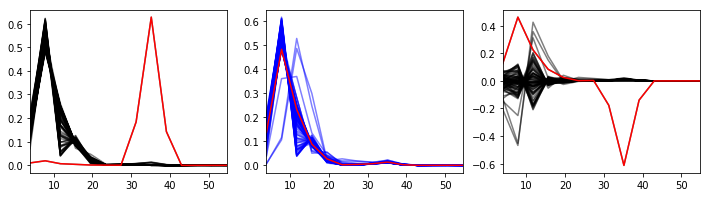

In [300]:
fig, ax  =plt.subplots(ncols=3,figsize=(12,3))


normed.plot(ax=ax[0],c='k',legend=False,alpha=0.5)
normed[focal_node_colnum].plot(ax=ax[0],c='r')

normed_ref.plot(ax=ax[1],c='b',legend=False,alpha=0.5)
normed_ref[focal_node_colnum].plot(ax=ax[1],c='r')

diff.plot(ax=ax[2],c='k',legend=False,alpha=0.5)
diff[focal_node_colnum].plot(ax=ax[2],c='r')


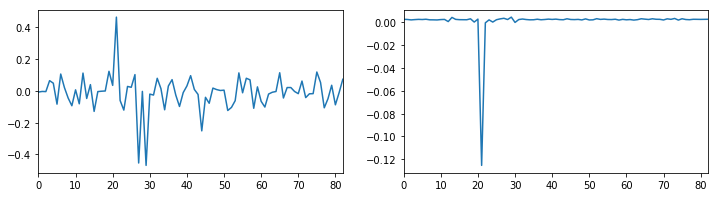

In [301]:
fig, ax = plt.subplots(ncols=2, figsize=(12,3))

pd.DataFrame(diff_alphapow)[0].plot(ax=ax[0])
pd.DataFrame(diff_gammapow)[0].plot(ax=ax[1])

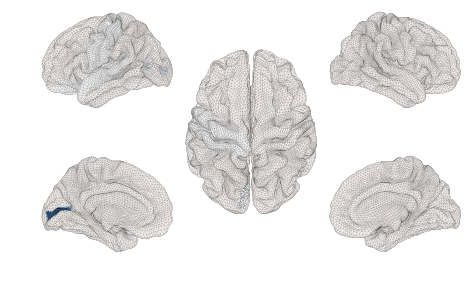

In [302]:
##

_cm = 'RdBu_r'
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
       'vmax': 0.1,'vmin': -0.1, 'alpha': None, 'linewidth': 0.05}

plot_surface_mpl_mv(vtx=vtx_l2k8_lhrh,tri=tri_l2k8_lhrh,hemi=hemi,reorient='fs',data=diff_gammapow_onsurf,
                    shade_kwargs=kws)          

#plt.colorbar()

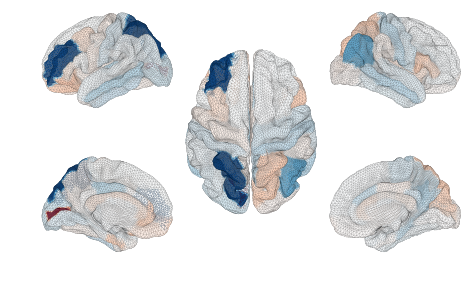

In [303]:
_cm = 'RdBu_r'
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
       'vmax': 0.5,'vmin': -0.5, 'alpha': None, 'linewidth': 0.05}
plot_surface_mpl_mv(vtx=vtx_l2k8_lhrh,tri=tri_l2k8_lhrh,hemi=hemi,reorient='fs',data=diff_alphapow_onsurf,
                    shade_kwargs=kws)          